# HW 2: Vision and Uncertainty 


*   Niyathi Allu
*   nallu002@ucr.edu
*   862392991



References :  


*   https://chat.openai.com/ 
*   https://pytorch.org/ 
*   https://mazhar-hussain.medium.com/semantic-image-segmentation-with-python-pytorch-c948aabceced 





In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # Define image transforms for both the input image AND the "label" image
    # Resize/crop images to be all the same size, a power of 2
    # Transform the label and image in the same way when changing size
    image_transforms = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    label_transforms = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        ToIntTensor()
    ])

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "~/Downloads/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.01
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)


Using downloaded and verified file: /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar
Extracting /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar to /Users/niyathiallu/Downloads/
Using downloaded and verified file: /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar
Extracting /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar to /Users/niyathiallu/Downloads/


In [ ]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    model.train()
    train_loss = 0.0

    for inputs, labels in train_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        labels = labels.squeeze(dim=1)

        calculated_loss = criterion(outputs['out'], labels)

        # Backward pass
        calculated_loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Calculate the average training loss
    train_loss /= len(train_dl.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            labels = labels.squeeze(dim=1)

            loss = criterion(outputs['out'], labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs['out'], 1)
            total += labels.numel()
            correct += (predicted == labels).sum().item()

            print(f"predicted shape: {predicted.shape}, labels shape: {labels.shape}")
            print(f"Total labels size {total}")
            print(f"Correctly predicted Values {correct}")
            # print(f"predicted values: {predicted}, labels values: {labels}")

    # Calculate the average validation loss and accuracy
    val_loss /= len(val_dl.dataset)
    accuracy = correct / total

    return train_loss, val_loss, accuracy



In [ ]:
train_losses, val_losses, accuracy_list = [], [], []
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracy_list.append(accuracy)

predicted shape: torch.Size([64, 128, 128]), labels shape: torch.Size([64, 128, 128])
Total labels size 1048576
Correctly predicted Values 415121
predicted shape: torch.Size([64, 128, 128]), labels shape: torch.Size([64, 128, 128])
Total labels size 2097152
Correctly predicted Values 805941
predicted shape: torch.Size([64, 128, 128]), labels shape: torch.Size([64, 128, 128])
Total labels size 3145728
Correctly predicted Values 1190945
predicted shape: torch.Size([21, 128, 128]), labels shape: torch.Size([21, 128, 128])
Total labels size 3489792
Correctly predicted Values 1366800
predicted shape: torch.Size([64, 128, 128]), labels shape: torch.Size([64, 128, 128])
Total labels size 1048576
Correctly predicted Values 714551
predicted shape: torch.Size([64, 128, 128]), labels shape: torch.Size([64, 128, 128])
Total labels size 2097152
Correctly predicted Values 1458414
predicted shape: torch.Size([64, 128, 128]), labels shape: torch.Size([64, 128, 128])
Total labels size 3145728
Correctly

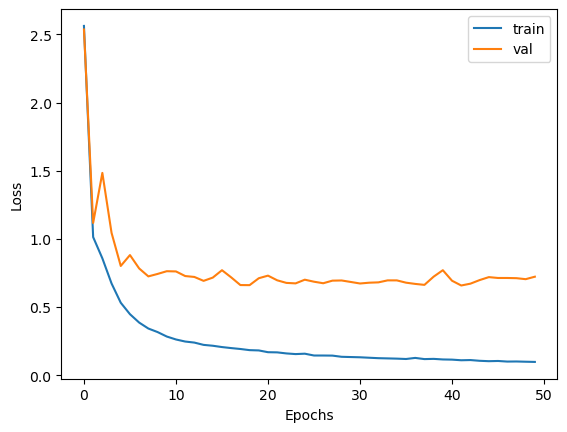

In [ ]:
# Plot train and validation loss
plt.plot(range(50), train_losses, label='train')
plt.plot(range(50), val_losses, label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

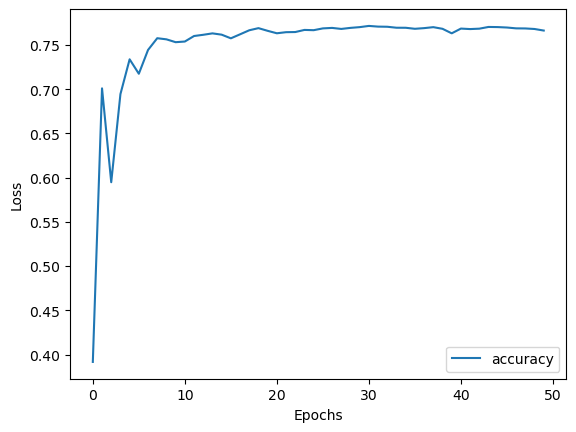

In [ ]:
# Plot train and validation loss
plt.plot(range(50), accuracy_list, label='accuracy')
# plt.plot(range(50), val_losses, label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


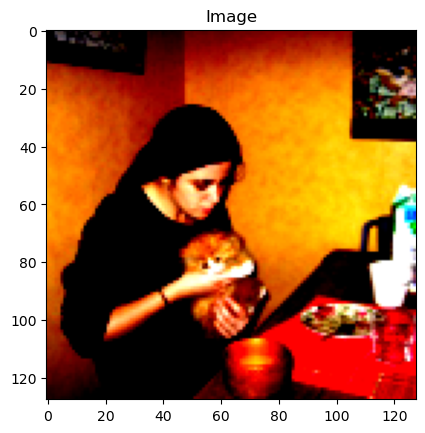

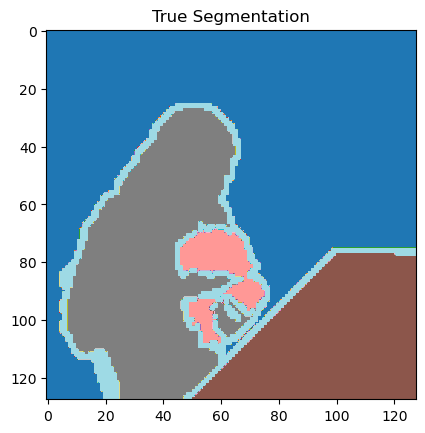

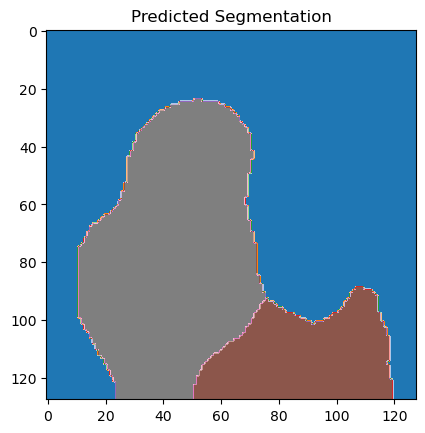

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the colormap
n_class = 21  # Number of segmentation classes
cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors

# Get an example image and its segmentation
inputs, labels = next(iter(val_dl))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)['out']
labels = labels.squeeze(1)  # Remove the channel dimension
predicted_label = outputs.argmax(axis=1)  # Get the class with the highest probability
predicted_label = predicted_label.cpu().numpy()  # Convert to numpy array
inputs = inputs.cpu().numpy()  # Convert input tensor to numpy array

# Print the image, true segmentation, and predicted segmentation
idx = np.random.randint(0, inputs.shape[0])
plt.imshow(inputs[idx].transpose(1, 2, 0))
plt.title("Image")
plt.show()

plt.imshow(labels[idx].cpu().numpy(), cmap=cmap, vmin=0, vmax=n_class)
plt.title("True Segmentation")
plt.show()

plt.imshow(predicted_label[idx], cmap=cmap, vmin=0, vmax=n_class)
plt.title("Predicted Segmentation")
plt.show()



In [ ]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

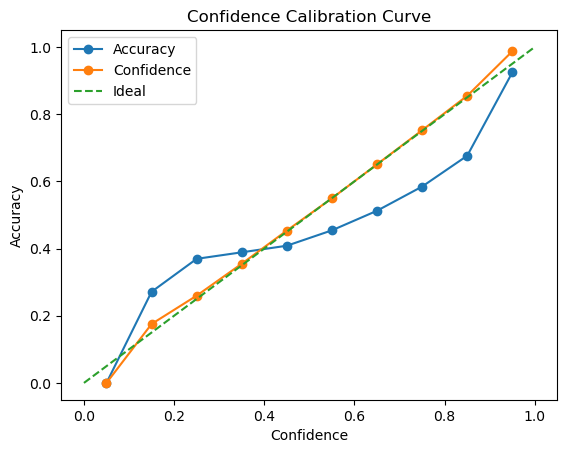

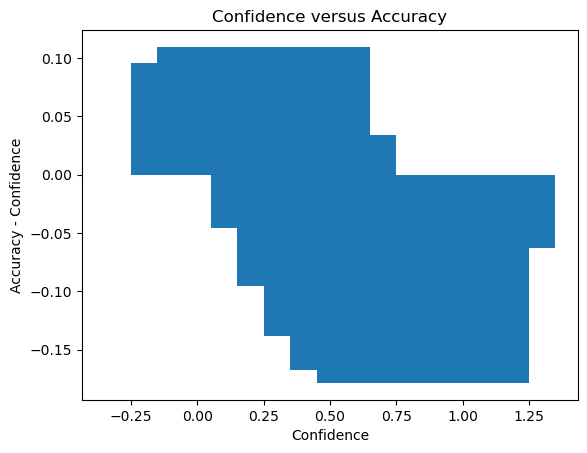

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss

# Calculate ECE
ece = np.sum(bin_frac * np.abs(bin_acc - bin_conf)) / np.sum(bin_frac)

# Plot confidence calibration curve
fig, ax = plt.subplots()
ax.plot(bin_centers, bin_acc, marker='o', label='Accuracy')
ax.plot(bin_centers, bin_conf, marker='o', label='Confidence')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
ax.set_title('Confidence Calibration Curve')
ax.legend()

# Plot confidence versus accuracy bar chart
fig, ax = plt.subplots()
ax.bar(bin_centers, bin_acc - bin_conf)
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy - Confidence')
ax.set_title('Confidence versus Accuracy')
plt.show()



# Calibration Error

In [3]:
print(f"Calibration error : {calibration_error}")

Calibration Error : 6.59%.
